<a href="https://colab.research.google.com/github/Calista-F/CCSN-gravitational-wave-denoising/blob/main/20220218_Wavelet_runthrough_Signal_60_20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pywt
from skimage.restoration import denoise_wavelet
import matplotlib.pyplot as plt
import pandas as pd
from math import log10, sqrt
import cv2
import numpy as np

In [2]:
from sklearn.metrics import  mean_squared_error, mean_absolute_error, max_error
import math

def get_rmse(y_target, y_computed):
  RMSE = mean_squared_error(y_target, y_computed, squared=False)
  return RMSE

In [3]:
from google.colab import auth
auth.authenticate_user()

import gspread
from gspread_dataframe import set_with_dataframe
from oauth2client.client import GoogleCredentials

gc = gspread.authorize(GoogleCredentials.get_application_default())

In [4]:
# Load worksheet
repo = gc.open_by_url('https://docs.google.com/spreadsheets/d/1VB7SaGWtdRc8lsV4EXCRuQfwXWYLnf8KbMgmsqezgZs/edit#gid=1342867710')
worksheet = repo.worksheet('CCSN_signal60_dist20.0')

#make a df
CCSN60 = worksheet.get_all_values()
ccsn_df = pd.DataFrame(CCSN60)
ccsn_df.columns = ccsn_df.iloc[0]
ccsn_df = ccsn_df.iloc[1:]

#make numeric
ccsn_df = ccsn_df.apply(pd.to_numeric)

In [5]:
def get_min_rmse(df):
  return df[df['RMSE'] == df['RMSE'].min()]

###Table 1. Denoising results for the CCSN signal s20a1o05 at a distance of 5 kpc (SNR = 3.9 dB).

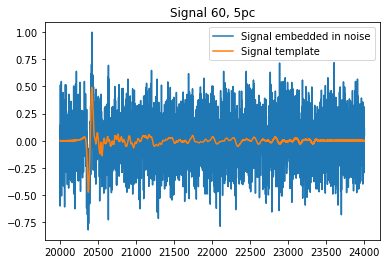

In [6]:
noisy_norm_df = ccsn_df['signal + noise'].loc[20000:24000]/max(ccsn_df['signal + noise'].loc[20000:24000])
signal_norm_df = ccsn_df['signal template'].loc[20000:24000]/max(ccsn_df['signal + noise'].loc[20000:24000])

plt.plot(noisy_norm_df, label ='Signal embedded in noise')
plt.title('Signal 60, 5pc')
plt.plot(signal_norm_df, label ='Signal template')
plt.legend()

Declare necessary lists for table 1

In [7]:
metrics = ['RMSE','MAE','MAX']
wavelets = ['sym5','db13','coif1']
sym_wavelets = ['sym'+str(i) for i in range(2,21)]
db_wavelets = ['db'+str(i) for i in range(1,39)]
coif_wavelets = ['coif'+str(i) for i in range(1,18)]
levels = np.arange(1,7,1)
methods = ['BayesShrink','VisuShrink']
indexcol = ['RMSE','MAE','MAX']

signalno = 'signal 60'
signaldistance = '5 kpc'

Create a main list that appends each line and each metric result

In [8]:
main_list = []

for m in methods:
  cols = []
  for i in range(len(sym_wavelets)):
    for l in range(len(levels)):
      #Make a dataframe for the denoised signal of the noisy normalized signal
      denoised_df = pd.DataFrame(denoise_wavelet(noisy_norm_df, method = m, mode ='hard', wavelet = sym_wavelets[i], wavelet_levels = levels[l], rescale_sigma = 'True'))
      
      #Create col1- a list that contains the signal properties (which signal template was used), denoising properties, and denoising performance metrics
      col1 = [str(m).upper() +', '+ sym_wavelets[i] + ' level ' + str(levels[l])] 
      col1.append(get_rmse(signal_norm_df, denoised_df))
      col1.append(mean_absolute_error(signal_norm_df, denoised_df))
      col1.append(max_error(signal_norm_df, denoised_df))

      #append this column to cols- a list of columns for the table 
      cols.append(col1)
  main_list.append(cols)

  main_array = np.array(main_list)

In [9]:
def denoising_metrics(wavelet_family, max_level):

  main_list = []
  for m in methods:
    cols = []
    for i in range(len(wavelet_family)):
      for l in range(len(np.arange(1,max_level,1))):
        #Make a dataframe for the denoised signal of the noisy normalized signal
        denoised_df = pd.DataFrame(denoise_wavelet(noisy_norm_df, method = m, mode ='hard', wavelet = wavelet_family[i], wavelet_levels = np.arange(1,max_level,1)[l], rescale_sigma = 'True'))
        
        #Create col1- a list that contains the signal properties (which signal template was used), denoising properties, and denoising performance metrics
        col1 = [str(m).upper() +', '+ wavelet_family[i] + ' level ' + str(levels[l])] 
        col1.append(get_rmse(signal_norm_df, denoised_df))
        col1.append(mean_absolute_error(signal_norm_df, denoised_df))
        col1.append(max_error(signal_norm_df, denoised_df))

        #append this column to cols- a list of columns for the table 
        cols.append(col1)
    main_list.append(cols)
  return np.array(main_list)

In [10]:
df_minrmse = pd.DataFrame()

Symlet wavelet

In [11]:

symlet_array = denoising_metrics(sym_wavelets, 7)
BayesSymdf = pd.DataFrame(data = symlet_array[0,:,1:], columns = metrics, index = symlet_array[0,:,0])
df_minrmse = df_minrmse.append(get_min_rmse(BayesSymdf))


VisuSymdf = pd.DataFrame(data = symlet_array[1,:,1:], columns = metrics, index = symlet_array[1,:,0])
df_minrmse = df_minrmse.append(get_min_rmse(VisuSymdf))

Daubechies wavelet

In [12]:
db_array = denoising_metrics(db_wavelets,6)
BayesDbdf = pd.DataFrame(data = db_array[0,:,1:], columns = metrics, index = db_array[0,:,0])
df_minrmse = df_minrmse.append(get_min_rmse(BayesDbdf))
VisuDbdf = pd.DataFrame(data = db_array[1,:,1:], columns = metrics, index = db_array[1,:,0])
df_minrmse = df_minrmse.append(get_min_rmse(VisuDbdf))

Coiflet wavelet

In [13]:
coif_array = denoising_metrics(coif_wavelets,6)
coif_array.shape
Bayescoifdf = pd.DataFrame(data = coif_array[0,:,1:], columns = metrics, index = coif_array[0,:,0])
df_minrmse = df_minrmse.append(get_min_rmse(Bayescoifdf))
Visucoifdf = pd.DataFrame(data = coif_array[1,:,1:], columns = metrics, index = coif_array[1,:,0])
df_minrmse = df_minrmse.append(get_min_rmse(Visucoifdf))

Minimum RMSEs per threshold method and wavelet family

In [14]:
df_minrmse

,RMSE,MAE,MAX
"BAYESSHRINK, sym17 level 6",0.0327315789374777,0.025044395744794765,0.13400636613764663
"VISUSHRINK, sym9 level 6",0.031180710306101114,0.024305969800440412,0.10042518093042355
"BAYESSHRINK, db34 level 5",0.036013944033157,0.028679074513143846,0.12778639917060167
"VISUSHRINK, db34 level 5",0.036013944033157,0.028679074513143846,0.12778639917060167
"BAYESSHRINK, coif16 level 5",0.035954351773977336,0.028664043873253074,0.12516575864105559
"VISUSHRINK, coif16 level 5",0.035954351773977336,0.028664043873253074,0.12516575864105559
